#### In these notes, we compute the value of
$$
     I(p) = \min \left\{ \int | \nabla f |^2 - \frac1p\int f^{2p}, \quad \int f^2 = 1\right\},
$$
in dimension 2. The minimiser is the positive solution to the equation
$$
    - \Delta f - f^{2p-1} = \mu f, \quad \int f^2 = 1.
$$
In radial coordinates, we have
$$
    I_d(p) = 2 \pi \int_0^\infty r^{d-1} | u' |^2 - \frac{2 \pi}{p} \int_0^\infty r^{d-1} u^{2p} 
    \quad \text{with} \quad 
    2 \pi \int_0^\infty r^{d-1} u^2 = 1.
$$
The Euler-Lagrange equations are
$$
    -u'' - (d-1) \frac{u'}{r} - u^{2p-1} = \mu u, \quad 2 \pi \int_0^\infty r^{d-1} u^2 = 1.
$$

In [15]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? 
Nothing done.


In [16]:
%pylab inline
import scipy
import scipy.linalg as LA
import scipy.sparse.linalg as SLA
import sys

Populating the interactive namespace from numpy and matplotlib


In [17]:
def integral(f, xx): 
    eps = xx[1] - xx[0]
    return sum(f)*eps #integral on \R^+

In [18]:
def energy(u, p, xx):
    eps = xx[1] - xx[0]
    #du = np.zeros(len(u)-1)
    du = (u[1:] - u[:-1])/eps
    return 2*np.pi*sum(du**2*xx[:-1] * eps) - 2*np.pi/p*sum(xx*u**(2*p) * eps)

In [19]:
#def energy2(u, p, xx):
#    eps = xx[1] - xx[0]
#    Nabla = np.eye(Ng, Ng, 1)  - np.eye(Ng, Ng)
#    Nabla /= eps
#    du = Nabla @ u
#    return 2*np.pi*eps*sum(du**2*xx) - 2*np.pi/p*sum(xx*u**(2*p) * eps)

In [20]:
def get_H(u, p, xx): #here is full matrix. Sparsity is possible
    eps = xx[1] - xx[0]
    
    Nabla = np.eye(Ng, Ng, 1)  - np.eye(Ng, Ng)
    Nabla /= eps
    
    potential=-np.diag(u**(2*p-2))
    return Nabla.T@diag(xx)@Nabla + potential*diag(xx)

In [21]:
def multHu(u, p, xx, a): #here is full matrix. Sparsity is possible
    eps = xx[1] - xx[0]
    
    da = (roll(a, -1) - a)/eps
    da[-1] = -a[-1]/eps #last element
    
    xda = xx*da
    
    dxda = (roll(xda, 1) - xda)/eps
    dxda[-1] = xda[-1]/eps
    
    return dxda - xx*u**(2*p-2)*a

In [22]:
def find_I2(u0, p, xx, tol=1e-7, Niter=1000, verbose = 1):
    assert abs( integral( xx * u0**2, xx) - 1/(2*pi)) < 1e-8, "Wrong number of particle in rho0"

    listu = []
    listE = []
    Ng = np.shape(xx)[0]
     
    un, En = u0, float('inf')
    if verbose:
        print("Iteration\tEnergy\n----------\t-----------")
        
    # main loop
    for n in range(Niter):
        
        vals, vecs = LA.eigh ( 2*pi*get_H(un, p, xx)*eps, 2*pi*diag(xx)*eps ) #generalised eigenvalue problem
        
        #def multH(a): return multHu(u, p, xx, a)
        #def multX(a): return xx*a
        #H = SLA.LinearOperator((Ng, Ng), matvec = multH)
        #X = SLA.LinearOperator((Ng, Ng), matvec = multX)
        #vals, vecs = SLA.eigsh ( 2*pi*eps*H, k = 1, M = 2*pi*eps*X ) #generalised eigenvalue problem


        un = abs ( vecs[:,0] )
        #print("norm = ", sqrt( 2*pi*integral( xx * un**2, xx ) ))
        #un = un / sqrt( 2*pi*integral( xx * un**2, xx ) )
        Enp1 = energy(un, p, xx)
        
        if verbose:
            print(n, "\t\t", Enp1)
        
        listu.append(un)
        listE.append(Enp1)
        
        if Enp1 > En:
            print("problem")
            return un, listu, listE
        
        if abs(Enp1 - En) < tol:
            return un, listu, listE
        En = Enp1
        
    print("did not converge")
    return u_n, listu, listenergy

In [23]:
# Test cell
# The case N = 1
Ng = 1000 # number of grid points in [0, L]
eps = 0.5
xx = array([eps/2 + n*eps for n in range(Ng)])

p = 1.1 # the p value

u0 = exp(-xx/6)
u0 = u0 / sqrt(2*pi*integral(xx * u0**2, xx) )

#plot(rr, u0)
u1, listu, listenergy = find_I2(u0, p, xx, tol=1e-7, Niter=100, verbose = 1)
print("min u = ", u1[-1])

Iteration	Energy
----------	-----------
0 		 -0.4969147238881572
1 		 -0.4993145720519999
2 		 -0.4998104875816042
3 		 -0.49993168329022214
4 		 -0.4999621531815817
5 		 -0.4999698016796488
6 		 -0.49997171286300574
7 		 -0.4999721889158392
8 		 -0.4999723072831103
9 		 -0.49997233668662705
min u =  0.0


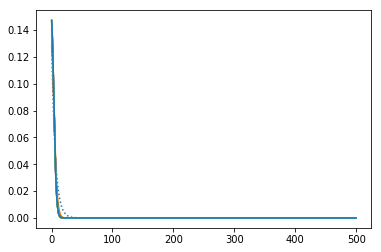

In [24]:
plot(xx, u0, ':')
for u in listu:
    plot(xx, u)

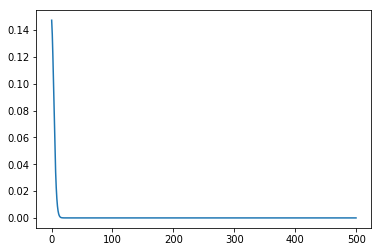

In [25]:
plot(xx, listu[-1])

## The computation

In [201]:
%%time

############################
Ng = 2000 # number of grid points in [0, L]
eps = 0.5
xx = array([eps/2 + n*eps for n in range(Ng)])

###########################

prange = linspace(1.01, 1.9, 50)
I2 = []
list_u2 = []

u0 = exp(-xx/4)
u0 = u0 / sqrt(2*pi*integral(xx * u0**2, xx) )

for p in prange:
    print("\nComputation for p = ", p)
    u1, listu, listenergy = find_I2(u0, p, xx, tol=1e-7, Niter=100, verbose = 1)
    I2.append(listenergy[-1])
    list_u2.append(u1)
    u0 = u1


#save result
I2p={"prange": prange, "I2":I2, "list_u2": list_u2} 
save("src/data/I2p_new.npy", I2p)


Computation for p =  1.01
Iteration	Energy
----------	-----------
0 		 -0.9140271142834964
1 		 -0.9154425783010915
2 		 -0.915685579966409
3 		 -0.9157394363210498
4 		 -0.9157523078917655
5 		 -0.9157554646678017
6 		 -0.9157562465582155
7 		 -0.9157564410268465
8 		 -0.9157564894847934

Computation for p =  1.0281632653061226
Iteration	Energy
----------	-----------
0 		 -0.7993667345153812
1 		 -0.8009174494232292
2 		 -0.8013458974730897
3 		 -0.8014585001016254
4 		 -0.8014872998521105
5 		 -0.8014945609833115
6 		 -0.8014963781958216
7 		 -0.8014968312704577
8 		 -0.8014969440179364
9 		 -0.8014969720482872

Computation for p =  1.046326530612245
Iteration	Energy
----------	-----------
0 		 -0.7076043560376795
1 		 -0.7080667637911606
2 		 -0.7081876550908559
3 		 -0.708218448937635
4 		 -0.7082261848111365
5 		 -0.708228114228886
6 		 -0.7082285936808319
7 		 -0.7082287126011656
8 		 -0.7082287420699018

Computation for p =  1.0644897959183675
Iteration	Energy
----------	------

7 		 -0.005613949255819446

Computation for p =  1.5912244897959185
Iteration	Energy
----------	-----------
0 		 -0.004034823782029188
1 		 -0.00405502813349592
2 		 -0.004063130468614421
3 		 -0.0040664591577888225
4 		 -0.004067845557849813
5 		 -0.004068428181055049
6 		 -0.004068674458782605
7 		 -0.004068778958468059
8 		 -0.004068823409335624

Computation for p =  1.6093877551020408
Iteration	Energy
----------	-----------
0 		 -0.002843290724167092
1 		 -0.0028612564677809515
2 		 -0.0028686591697314164
3 		 -0.0028717857746722985
4 		 -0.0028731256130528366
5 		 -0.0028737053289547955
6 		 -0.00287395776593803
7 		 -0.0028740681545529577
8 		 -0.0028741165614039775

Computation for p =  1.6275510204081631
Iteration	Energy
----------	-----------
0 		 -0.0019435477295765878
1 		 -0.001959481087925315
2 		 -0.0019662246185478895
3 		 -0.001969152206073203
4 		 -0.001970443003465145
5 		 -0.0019710181207575122
6 		 -0.001971276179403195
7 		 -0.001971392521008092
8 		 -0.00197144513

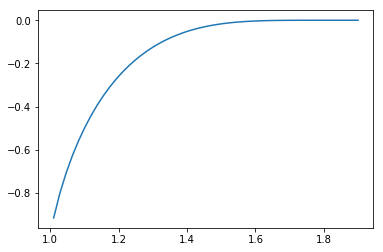

In [202]:
plot(prange, I2)

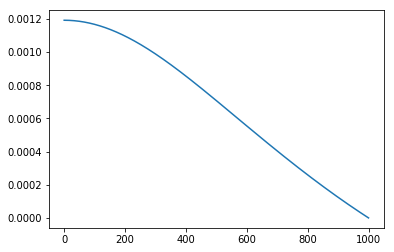

In [204]:
plot(xx, list_u2[-1])